## 0. Environment API

**Welcome to Environment API**
This section explains some of the API for interacting with the game environment. API stands for Application Programming Interface, it details information about the structure of the code so you are aware what information you can obtain from the environment and use within you agent's solution / reward functions





### 0.1 Map

The environment map coordinate system is as follows. Some key things to note:

1. The center of the map is the origin
2. Positive X direction is pointed torwards the right
3. Positive Y direction is pointed upwards

Also, here are some key points and dimensions (in game coordinates):
1. Screen Dimensions
- width: 14.9
- height: 9.94
2. Ground1:
- width: 4.15
- points: [(-7.0, 2.85), (-2.0, 2.85), (-2.0, 7.0), (-7.0, 7.0)]
  - meaning ground is at y=2.85 between x=-7.0 and x=-2.0
3. Ground2:
- width: 4.15
- points: [(2.0, 0.85), (7.0, 0.85), (7.0, 5.0), (2.0, 5.0)]
  - meaning ground is at y=0.85 between x=2.0 and x=7.0
4. Moving Stage (NEW FOR THIS YEAR!)
- width: 2
- height: 0.2
- moves between (1,0) and (-1,2) *centered on endpoints

You can use the image to scale and figure out regions within the game which you can use to define your agent behaviour and/or reward functions!



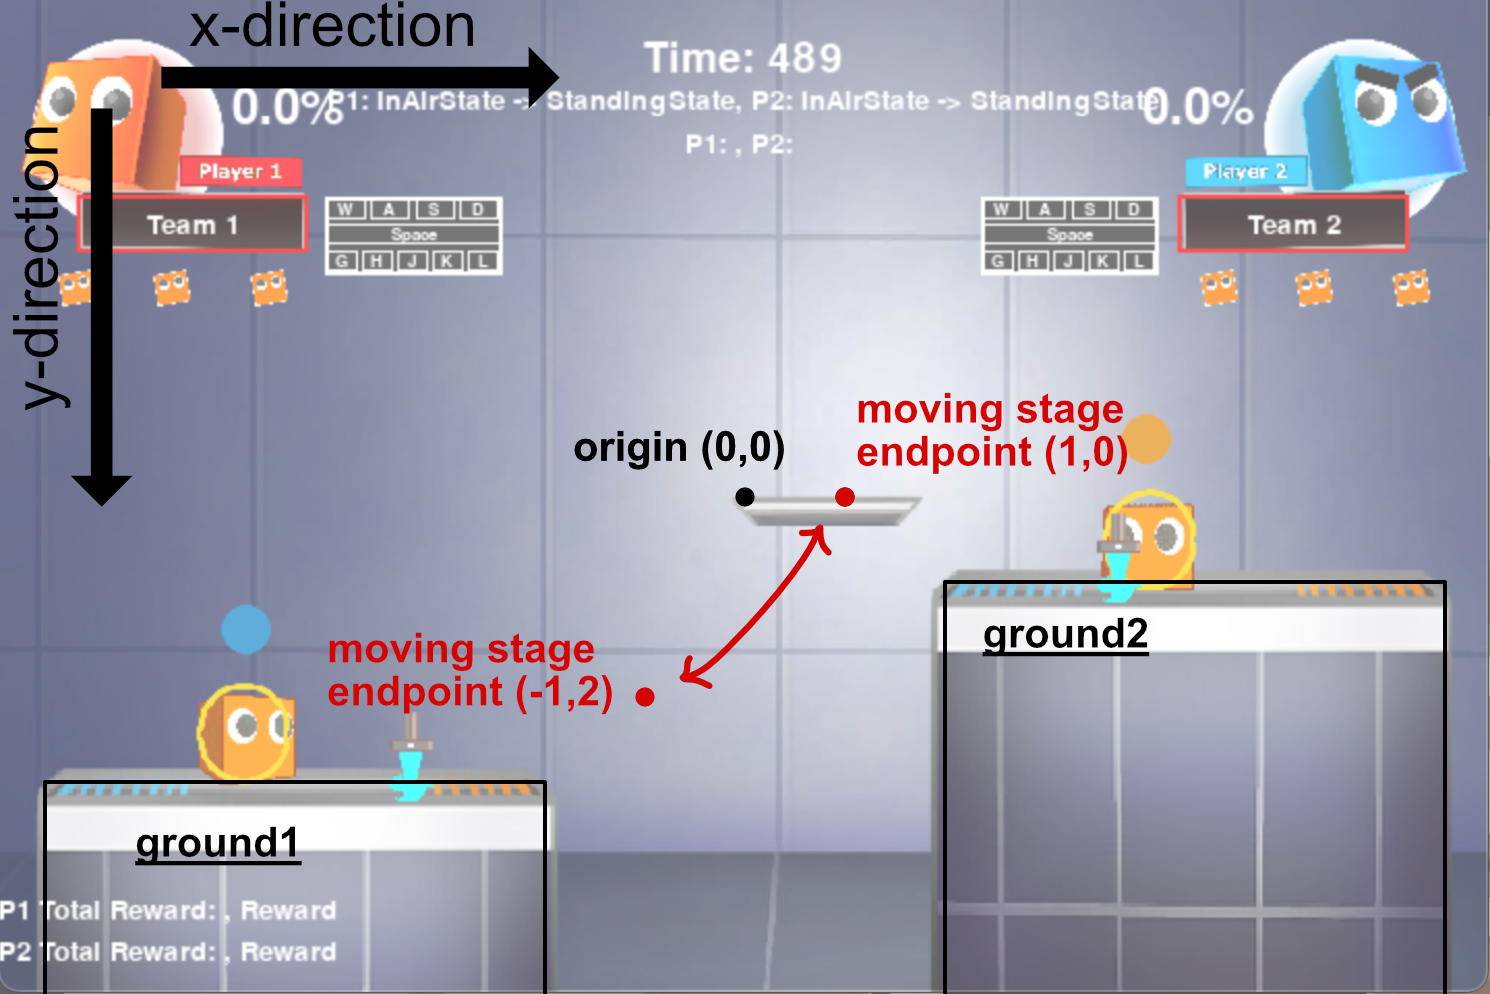

### **0.2 Spawners & Weapons (NEW FOR THIS YEAR!)**

There are three weapon types available:
- Punch (equipped by default)
- Hammer  

  <img src="/Users/martintin/Desktop/UTMIST-AI2/environment/hammervfx/idle.gif" alt="Hammer weapon">
- Spear  

  <img src="/Users/martintin/Desktop/UTMIST-AI2/environment/spearvfx/idle.gif" alt="Spear weapon">

There are two types of spawners:

- **random spawner:** appears as glowing sword; when equipped, random weapon is equipped  
  <img src="/Users/martintin/Desktop/UTMIST-AI2/environment/spawnervfx/idle.gif" alt="Random spawner (flaming sword)" width="250">

  - **IMPORTANT!** random spawner will be marked active but will be unable to be picked up for 18 frames to account for falling animation
  - cooldown frames: random between 500 to 700
  - despawn frames: 350

- **dropped weapon spawner:** appears when equipped weapon is dropped; appears as a spear or hammer; when equipped, particular weapon shown is equipped
  - despawn frames: 250


### 0.3 Environment Variables

For accessing variables about the environment (including objects, agents (player, opponent), etc) you can use the following format:

In [ ]:
# Agents
env.objects["player"]
env.objects["opponent"]

# Agent Position
env.objects["player"].body.position.x   # X position during frame
env.objects["player"].body.position.y   # Y position during frame

env.objects["player"].body.position.x_change  # Change in x direction position between frames
env.objects["player"].body.position.y_change  # Change in y direction position between frames

env.objects["player"].body.velocity.x # X velocity of agent
env.objects["player"].body.velocity.y # Y velocity of agent

# Agent Characteristics
env.objects["player"].damage_taken_total      # Integer value of total damage taken
env.objects["player"].damage_taken_this_stock  # Integer value of damage taken this stock life
env.objects["player"].damage_taken_this_frame  # Integer value
#env.objects["player"].weapon_held_this   # True or False

# Time
env.time_elapsed  # Time that has elapsed since start of game
env.current_frame # Current frame number

# Spawners, weapons, platforms

env.objects["player"].weapon # "Punch", "Hammer", or "Spear"

env.objects['platform1'].body.position # (x,y)
env.objects['platform1'].velocity_x
env.objects['platform1'].velocity_y

spawners = env.get_spawner_info()

"""
spawners is array containing all active spawners
Each entry is in the form of [weapontype, world_pos], where world_pos is in form (x,y)
Weapon_type can be “Spear”, “Punch”, “Hammer” or “Random” for random spawner
"""

## 1. Reward Function Library

**Welcome to the Reward Function Library**

This section contains some basic already pre-implemented reward functions for you to use for training your agents! The reward functions that have been implemented correspond to some of the ones in the technical guide. We recommend you use these reward functions as starting points for tweaking and designing your own!

As a starting point/hint, we’ve also included some ideas of reward functions that might be good to implement yourself! If you are struggling to implement some of these feel free to ask questions on the discord in the question hub!





### 1.1 Existential State/Env Rewards

In [ ]:
class RewardMode(Enum):
    ASYMMETRIC_OFFENSIVE = 0
    SYMMETRIC = 1
    ASYMMETRIC_DEFENSIVE = 2

def damage_interaction_reward(
    env: WarehouseBrawl,
    mode: RewardMode = RewardMode.SYMMETRIC,
) -> float:
    """
    Computes the reward based on damage interactions between players.

    Modes:
    - ASYMMETRIC_OFFENSIVE (0): Reward is based only on damage dealt to the opponent
    - SYMMETRIC (1): Reward is based on both dealing damage to the opponent and avoiding damage
    - ASYMMETRIC_DEFENSIVE (2): Reward is based only on avoiding damage

    Args:
        env (WarehouseBrawl): The game environment
        mode (DamageRewardMode): Reward mode, one of DamageRewardMode

    Returns:
        float: The computed reward.
    """
    # Getting player and opponent from the enviornment
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]

    # Reward dependent on the mode
    damage_taken = player.damage_taken_this_frame
    damage_dealt = opponent.damage_taken_this_frame

    if mode == RewardMode.ASYMMETRIC_OFFENSIVE:
        reward = damage_dealt
    elif mode == RewardMode.SYMMETRIC:
        reward = damage_dealt - damage_taken
    elif mode == RewardMode.ASYMMETRIC_DEFENSIVE:
        reward = -damage_taken
    else:
        raise ValueError(f"Invalid mode: {mode}")

    return reward

In [ ]:
def danger_zone_reward(
    env: WarehouseBrawl,
    zone_penalty: int = 1,
    zone_height: float = 4.2
) -> float:
    """
    Applies a penalty for every time frame player surpases a certain height threshold in the environment.

    Args:
        env (WarehouseBrawl): The game environment.
        zone_penalty (int): The penalty applied when the player is in the danger zone.
        zone_height (float): The height threshold defining the danger zone.

    Returns:
        float: The computed penalty as a tensor.
    """
    # Get player object from the environment
    player: Player = env.objects["player"]

    # Apply penalty if the player is in the danger zone
    reward = -zone_penalty if player.body.position.y >= zone_height else 0.0

    return reward


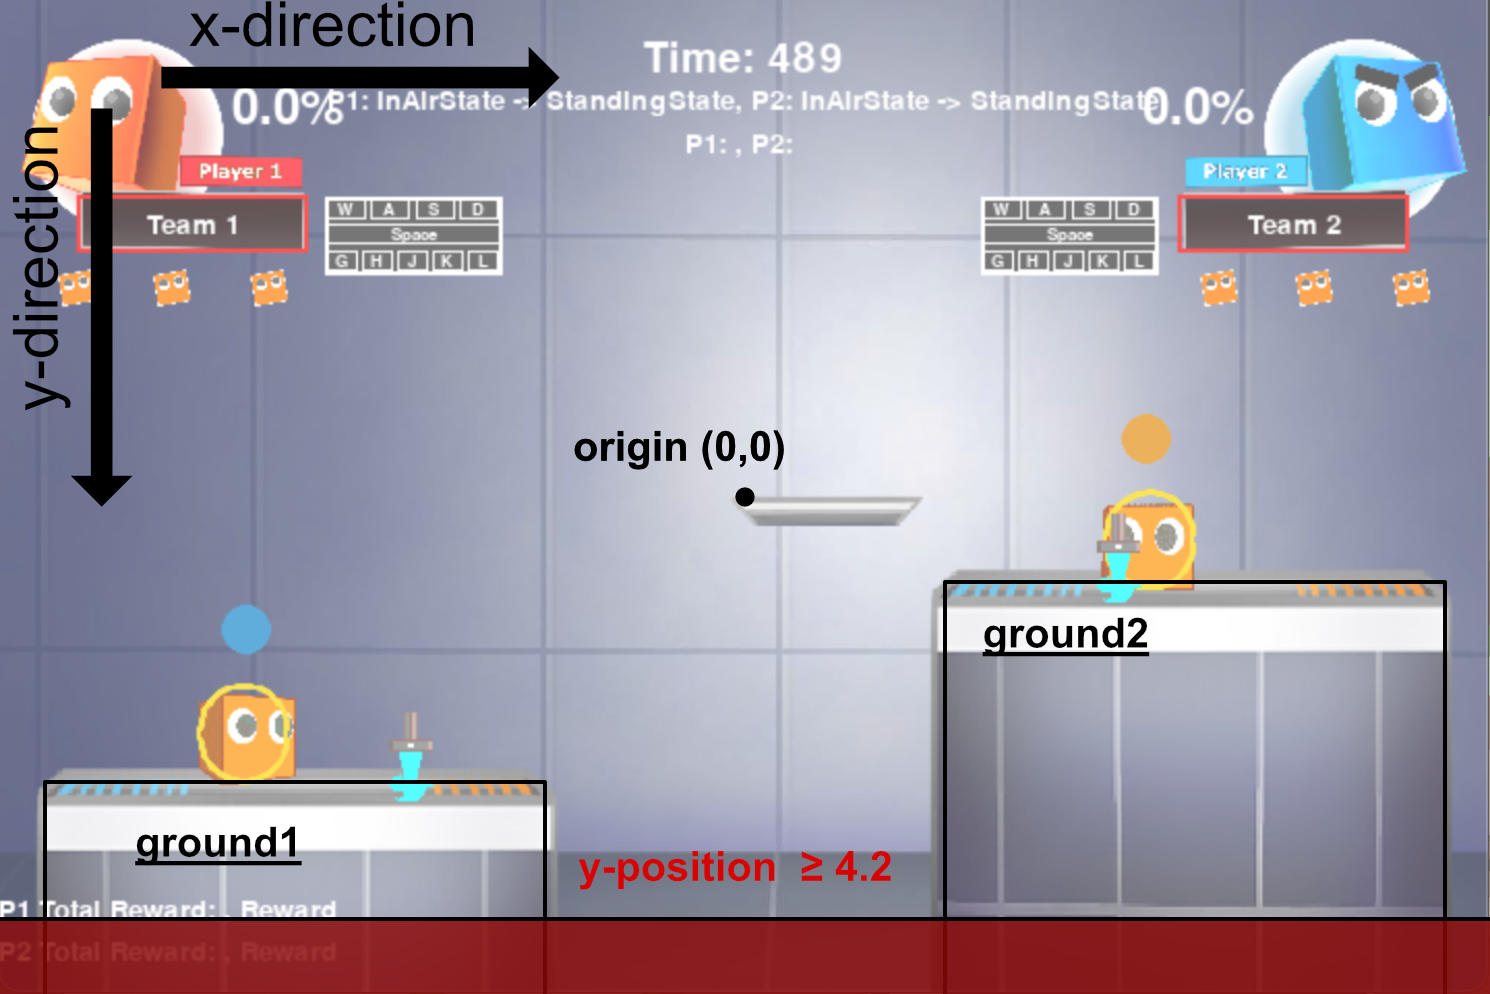

NOTE: that this danger_height being 4.2 corresponds to the following

In [ ]:
# TODO: This reward function has not been written and is left as an exercise to try and implement
#       yourself. Think about the following before implementing:
#
#       - While having a stock lead is generally good in fighting games,
#         how would this reward influence agent behaviour?
#       - Is this behaviour even desirable?
#       - Is this behaviour more valuable near the beggingin or end of the match,
#         and based on that answer how can you change the reward so it considers time?


def stock_advantage_reward(
    env: WarehouseBrawl,
    success_value: float = 0, #TODO
) -> float:

    """
    Computes the reward given for every time step your agent is edge guarding the opponent.

    Args:
        env (WarehouseBrawl): The game environment
        success_value (float): Reward value related to having/gaining a weapon (however you define it)
    Returns:
        float: The computed reward.
    """
    reward = 0.0
    # TODO: Write the function

    return reward


 ### 1.2 Modulo Existential Reward

In [ ]:
def move_to_opponent_reward(
    env: WarehouseBrawl,
) -> float:
    """
    Computes the reward based on whether the agent is moving toward the opponent.
    The reward is calculated by taking the dot product of the agent's normalized velocity
    with the normalized direction vector toward the opponent.

    Args:
        env (WarehouseBrawl): The game environment

    Returns:
        float: The computed reward
    """
    # Getting agent and opponent from the enviornment
    player: Player = env.objects["player"]
    opponent: Player = env.objects["opponent"]

    # Extracting player velocity and position from environment
    player_position_dif = np.array([player.body.position.x_change, player.body.position.y_change])

    direction_to_opponent = np.array([opponent.body.position.x - player.body.position.x,
                                      opponent.body.position.y - player.body.position.y])

    # Prevent division by zero or extremely small values
    direc_to_opp_norm = np.linalg.norm(direction_to_opponent)
    player_pos_dif_norm = np.linalg.norm(player_position_dif)

    if direc_to_opp_norm < 1e-6 or player_pos_dif_norm < 1e-6:
        return 0.0

    # Compute the dot product of the normalized vectors to figure out how much
    # current movement (aka velocity) is in alignment with the direction they need to go in
    reward = np.dot(player_position_dif / direc_to_opp_norm, direction_to_opponent / direc_to_opp_norm)

    return reward

In [ ]:
# TODO: This reward function has not been written and is left as an exercise to try and implement
#       yourself. Think about the following before implementing:
#
#       - When does "edge-guarding" happen?
#       - Where does the oppoent have to be or be moving?
#       - Where does your player have to be or be moving?
#       - Where does the ledge have to be relative to the agents?

def edge_guard_reward(
    env: WarehouseBrawl,
    success_value: float = 0, #TODO
    fail_value: float = 0,    #TODO
) -> float:

    """
    Computes the reward given for every time step your agent is edge guarding the opponent.

    Args:
        env (WarehouseBrawl): The game environment
        success_value (float): Reward value for the player hitting first
        fail_value (float): Penalty for the opponent hitting first

    Returns:
        float: The computed reward.
    """
    reward = 0.0
    # TODO: Write the function

    return reward


### 1.3 Single Event/Sparse Reward

**How to Implement an Event/Sparse Reward: Signals**

Other types of rewards check every timestep checks if certain conditions are true (a method known as **polling**).

Events related to sparse rewards only happen very rarely, so it would be very inefficient to check them every time step. For this reason we introduce something called **signals**.

A signal is a way to trigger a response when an event occurs, without needing to constantly check for the event. This is much more efficient because the system only responds when something relevant happens, rather than checking continuously.

In this setup, a signal serves as a message or notification that something has occurred in the environment (e.g., a player achieving a knockout).

When a signal is emitted, it notifies all functions that have been connected to it (known as **handlers**), and those functions can then take the appropriate action, such as rewarding the agent for the achievement. The reward functions will be handlers in this case.

**How to implment a signal and a corresponding sparse reward**

To make a reward function for sparse rewards you need to write the reward funciton and set up the signal. Below is some code indicating how the signal class is organized - you won't have to modify this asa it is already inside your notebook. What you will have to do is

1.   Create an instance of this signal class
2.   Write a reward function
3.   Connect the reward function to the signal
4.   Put the signal emission whenever you want it to activate

In [ ]:
# Signal class (DO NOT ADD TO NOTEBOOK - already implmented)

class Signal:
    def __init__(self):
        self._handlers = []

    def connect(self, handler):
        self._handlers.append(handler)

    def emit(self, *args, **kwargs):
        for handler in self._handlers:
            handler(*args, **kwargs)

# 1. Create instance of signal (in this case it's knockout)
knockout_signal = Signal()

# 2. Define the knockout reward (note it is defined in the next cell)

# 3. Connect reward functions to signal using .connect
knockout_signal.connect(knockout_reward)

# 4. Wherever in the code you want the signal to activate, put signal emit,
#    including what value you want to pass along to your reward funciton handler

knockout_signal.emit(agent="player")    # Signal passing argument "player", indicating player was knocked out
knockout_signal.emit(agent="opponent")  # Signal passing argument "opponent", indicating opponent was knocked out

In [ ]:
class RewardMode(Enum):
    ASYMMETRIC_OPPONENT = 0
    SYMMETRIC = 1
    ASYMMETRIC_PLAYER = 2


def knockout_reward(
    env: WarehouseBrawl,
    agent: str = "player",
    mode: RewardMode = RewardMode.SYMMETRIC,
    knockout_value_opponent: float = 50.0,
    knockout_value_player: float = 50.0,


) -> float:
    """
    Computes the reward based on who won the match.

    Modes:
    - ASYMMETRIC_OPPONENT (0): Reward is based only on the opponent being knocked out
    - SYMMETRIC (1): Reward is based on both agents being knocked out
    - ASYMMETRIC_PLAYER (2): Reward is based only on your own plauyer being knocked out

    Args:
        env (WarehouseBrawl): The game environment
        agent(str): The agent that was knocked out
        mode (RewardMode): Reward mode, one of RewardMode
        knockout_value_opponent (float): Reward value for knocking out opponent
        knockout_value_player (float): Reward penalty for player being knocked out

    Returns:
        float: The computed reward.
    """
    reward = 0.0

    # Mode logic to compute reward
    if mode == RewardMode.ASYMMETRIC_OPPONENT:
        if agent == "opponent":
            reward = knockout_value_opponent # Reward for opponent being knocked out
    elif mode == RewardMode.SYMMETRIC:
        if agent == "player":
            reward = -knockout_value_player  # Penalty for player getting knocoked out
        elif agent == "opponent":
            reward = knockout_value_opponent # Reward for opponent being knocked out
    elif mode == RewardMode.ASYMMETRIC_PLAYER:
        if agent == "player":
            reward = -knockout_value_player  # Penalty for player getting knocked out

    return reward

In [ ]:
def win_reward(
    env: WarehouseBrawl,
    agent: str = "player",
    win_value: float = 300.0,
    lose_value: float = 200.0,
) -> float:

    """
    Computes the reward based on knockouts.


    Args:
        env (WarehouseBrawl): The game environment
        agent(str): The agent that won
        win_value (float): Reward value for knocking out opponent
        lose_value (float): Reward penalty for player being knocked out

    Returns:
        float: The computed reward.
    """

    reward = win_value if agent == "player" else -lose_value
    return reward

In [ ]:
def on_equip_reward(env: WarehouseBrawl, agent: str) -> float:
    if agent == "player":
        if env.objects["player"].weapon == "Hammer":
            return 2.0
        elif env.objects["player"].weapon == "Spear":
            return 1.0
    return 0.0

def on_drop_reward(env: WarehouseBrawl, agent: str) -> float:
    if agent == "player":
        if env.objects["player"].weapon == "Punch":
            return -1.0
    return 0.0

## 2. Training Process

This section contains information on how you would start a training process with the agent. 
In the `user/` folder you'll see a `train_agent.py` file in which you can run to train your agent!

For agent training, there are three main sections to consider:

### 2.1 Defining your agent type (or the agent's `class`)

In the file we have provided various types of Agents that **extend an Agent base class** such as SB3Agent (for running the model on SB3 algorithms like PPO), or a BasedAgent (if-statement agent). <br> For reference, the Agent class that all Agents extend is provided below:

In [ ]:
class Agent(ABC):
    def __init__(
            self,
            file_path: Optional[str] = None
        ):

        # If no supplied file_path, load from gdown (optional file_path returned)
        if file_path is None:
            file_path = self._gdown()

        self.file_path: Optional[str] = file_path
        self.initialized = False

    def get_env_info(self, env):
        if isinstance(env, Monitor):
            self_env = env.env
        else:
            self_env = env
        self.observation_space = self_env.observation_space
        self.obs_helper = self_env.obs_helper
        self.action_space = self_env.action_space
        self.act_helper = self_env.act_helper
        self.env = env
        self._initialize()
        self.initialized = True

    def get_num_timesteps(self) -> int:
        if hasattr(self, 'model'):
            return self.model.num_timesteps
        else:
            return 0

    def update_num_timesteps(self, num_timesteps: int) -> None:
        if hasattr(self, 'model'):
            self.model.num_timesteps = num_timesteps

    @abstractmethod
    def predict(self, obs) -> spaces.Space:
        pass

    def save(self, file_path: str) -> None:
        return

    def reset(self) -> None:
        return

    def _initialize(self) -> None:
        """

        """
        return

    def _gdown(self) -> Optional[str]:
        """
        Loads the necessary file from Google Drive, returning a file path.
        Or, returns None, if the agent does not require loaded files.

        :return:
        """
        return

### 2.2 Reward Function API

In the file, you will be defining all of your reward/signal functions that you will be using and compiling them into a `gen_reward_manager` method using `RewTerm` wrappers. 

- A `RewTerm` wraps your defined reward function and combines it with a `weight` and a `params` dict. 
    - The `weight` parameter defines **how important** your specific reward function is, where your reward will be multiplied by a weight importance value
    - If your reward function has additional parameter inputs other than `env: WarehouseBrawl`, you need to define your inputs in `params` as a dict, where the key-value pair is in the form: `{ 'parameter_name': actual_parameter }`
    - The signal subscriptions is a `Dict[function_name, Tuple(signal_name, RewTerm)]`

In [ ]:
def gen_reward_manager():
    reward_functions = {
        #'target_height_reward': RewTerm(func=base_height_l2, weight=0.0, params={'target_height': -4, 'obj_name': 'player'}),
        'danger_zone_reward': RewTerm(func=danger_zone_reward, weight=0.5),
        'damage_interaction_reward': RewTerm(func=damage_interaction_reward, weight=1.0),
        #'head_to_middle_reward': RewTerm(func=head_to_middle_reward, weight=0.01),
        #'head_to_opponent': RewTerm(func=head_to_opponent, weight=0.05),
        'penalize_attack_reward': RewTerm(func=in_state_reward, weight=-0.04, params={'desired_state': AttackState}),
        'holding_more_than_3_keys': RewTerm(func=holding_more_than_3_keys, weight=-0.01),
        #'taunt_reward': RewTerm(func=in_state_reward, weight=0.2, params={'desired_state': TauntState}),'
    }
    signal_subscriptions = {
        'on_win_reward': ('win_signal', RewTerm(func=on_win_reward, weight=50)),
        'on_knockout_reward': ('knockout_signal', RewTerm(func=on_knockout_reward, weight=8)),
        'on_combo_reward': ('hit_during_stun', RewTerm(func=on_combo_reward, weight=5)),
    }
    return RewardManager(reward_functions, signal_subscriptions)

### 2.3 Train Function

In the train function, there a few things that you can change and should be aware about. This section will go over this.

#### 2.3.1 Initializing your agent:
As mentioned in Part 1, you need to define the agent type that you will use. 

If you are starting training from scratch, initializing an agent with no file_path:

In [ ]:
my_agent = RecurrentPPOAgent()

If you want to continue training a model from a specific timestep, load the `file_path` of the model:

In [ ]:
my_agent = RecurrentPPOAgent(file_path='checkpoints/experiment_6/rl_model_24576_steps')

#### 2.3.2 Self-play settings:
When interacting with our self-play API, you can choose either `SelfPlayRandom` or `SelfPlayLatest`. 
- `SelfPlayLatest` will learn against the latest saved model
- `SelfPlayRandom` will learn against a full randomly-selected list of previously saved models

By default it is set to `SelfPlayRandom`.

In [ ]:
selfplay_handler = SelfPlayRandom(
    partial(type(my_agent)), # Agent class and its keyword arguments
)

#### 2.3.3 Save handler:
The `SaveHandler` allows you to choose the configurations for saving your agent for self-play.

Default values are set below. 

In [ ]:
save_handler = SaveHandler(
    agent=my_agent, # Agent to save
    save_freq=100_000, # Save frequency
    max_saved=40, # Maximum number of saved models
    save_path='checkpoints', # Save path
    run_name='experiment_6',
    mode=SaveHandlerMode.FORCE # Save mode, FORCE or RESUME
)

**NOTE**: If you are continuing training from a specific timestep, you have to make sure that your `save_path` and `run_name` are consistent with that previous train session and your `mode` is set to `SaveHandlerMode.RESUME`.

#### 2.3.4 Opponent config:
You can set the opponent configurations for self-play here, in the form of:
`Tuple(probability to play against specific agent, agent)`

In [ ]:
opponent_specification = {
    'self_play': (8, selfplay_handler),
    'constant_agent': (0.5, partial(ConstantAgent)),
    'based_agent': (1.5, partial(BasedAgent)),
}

## 3. Running a Demo Match Locally

We have provided a file located in `user/demo_match.py` file that you can run to test a `SubmittedAgent`. You can set an Agent to the player and opponent and run a real-time match locally. 

The example below runs a `UserInputAgent` (player-controlled) vs. a `SubmittedAgent` (loading from a `file_path`)

In [ ]:
my_agent = UserInputAgent()
opponent = SubmittedAgent(file_path="checkpoints/experiment_6/rl_model_78576_steps")